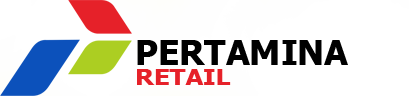

# Analisis Data Transaksi Harian SPBU

## Deskripsi

Program ini dirancang untuk melakukan analisis data transaksi SPBU. Program ini membaca file CSV yang diunggah, mengurutkan data berdasarkan SPBU, dispenser, dan waktu transaksi, dan menghitung beberapa metrik kinerja.

## Langkah-langkah Penggunaan

1. **Unggah File CSV:**
   - Jalankan program dan pilih opsi "Upload" untuk mengunggah file CSV yang berisi data transaksi SPBU.

2. **Pemrosesan Data:**
   - Program akan membaca file CSV dan melakukan beberapa transformasi pada data, termasuk pengurutan berdasarkan SPBU, dispenser, dan waktu transaksi.
   - Selisih waktu antar transaksi dan waktu normal dihitung untuk setiap entri.

3. **Penandaan Indikator:**
   - Program menghitung kolom "Indikator" berdasarkan kondisi tertentu.
   - Jika kondisi terpenuhi, kolom "Indikator" akan berisi 'X', jika tidak, akan berisi 'Done'.

4. **Pembuatan Laporan:**
   - Data yang telah diproses disimpan dalam file Excel dengan nama "Report.xlsx".
   - Selain itu, program membuat laporan ringkas untuk beberapa SPBU yang ditentukan.

5. **Unduh Laporan:**
   - Link untuk mengunduh laporan disediakan di akhir eksekusi program.

## SPBU yang Dianalisis

Program ini melakukan analisis ringkas untuk beberapa SPBU yang diidentifikasi. Daftar SPBU yang dianalisis dapat ditemukan di dalam kode sumber pada bagian "Summary analysis for specific SPBU numbers".

## Catatan Penting

- Pastikan file input adalah dalam format CSV dan memiliki kolom yang sesuai dengan yang diharapkan oleh program.
- Program ini melakukan beberapa transformasi pada data, dan output dapat bervariasi tergantung pada karakteristik data yang diunggah.

## Kredit

Program ini dikembangkan oleh Dimas Farhanditama.

Jangan ragu untuk menghubungi dfarhanditama@gmail.com untuk pertanyaan atau masukan.

Terima kasih telah menggunakan program ini!

In [ ]:
import pandas as pd
from google.colab import files

# Install xlsxwriter if not already installed
!pip install xlsxwriter

# Upload the Excel file manually in Google Colab
uploaded_files = files.upload()

# Check if any files were uploaded
if not uploaded_files:
    print("No files were uploaded. Please upload the required file and try again.")
else:
    # Adjust the file name if the uploaded file has a different name
    file_name = next(iter(uploaded_files))
    df = pd.read_csv(file_name, sep=';')

    df['Jam'] = pd.to_datetime(df['Jam'], format='%H:%M:%S', errors='coerce').dt.time

    # Sort the DataFrame based on 'Jam' and 'Dispenser'
    df_sorted = df.sort_values(by=['No spbu', 'No dispenser', 'Jam'])

    df_sorted.reset_index(inplace=True)
    df_sorted.drop(columns='index', inplace=True)

    df_sorted['Jam Sebelumnya'] = df_sorted['Jam'].shift(1)
    df_sorted['Jam Sebelumnya'] = pd.to_datetime(df_sorted['Jam Sebelumnya'], format='%H:%M:%S', errors='coerce').dt.time

    # Calculate the timedelta, replacing NaT with a default time
    df_sorted['Selisih Waktu'] = (pd.to_datetime(df_sorted['Jam'], format='%H:%M:%S', errors='coerce') -
                                   pd.to_datetime(df_sorted['Jam Sebelumnya'], format='%H:%M:%S', errors='coerce', exact=False)).fillna(pd.Timedelta(seconds=0))

    # Set Selisih Waktu to 0 if No spbu is different
    df_sorted['Selisih Waktu'] = df_sorted.apply(
        lambda row: pd.Timedelta(seconds=0) if row.name == 0 or df_sorted.at[row.name - 1, 'No spbu'] != row['No spbu'] else row['Selisih Waktu'],
        axis=1
    )

    # Convert the 'Selisih Waktu' column to time type and only store hour values
    df_sorted['Selisih Waktu'] = pd.to_timedelta(df_sorted['Selisih Waktu']).dt.total_seconds().astype(int)
    df_sorted['Selisih Waktu'] = pd.to_datetime(df_sorted['Selisih Waktu'], unit='s').dt.strftime('%H:%M:%S')

    df_sorted['Waktu Normal'] = ((df_sorted['Volume (Liter)'] / 40) + 0.5) * 0.000694444444444444

    # Convert the 'Waktu Normal' column to time type and only store hour values
    df_sorted['Waktu Normal'] = pd.to_timedelta(df_sorted['Waktu Normal'], unit='D').dt.total_seconds().astype(int)
    df_sorted['Waktu Normal'] = pd.to_datetime(df_sorted['Waktu Normal'], unit='s').dt.strftime('%H:%M:%S')

    # Create a DataFrame df_indikator to calculate the 'Indikator' column
    df_indikator = df_sorted.copy()

    # Calculate the 'Indikator' column based on Excel formula
    df_indikator['Indikator'] = df_indikator.apply(lambda row: 'X' if (
        row.name > 0 and  # Check that the index is greater than 0
        row['Volume (Liter)'] > 60 and
        pd.to_timedelta(row['Selisih Waktu']) < pd.to_timedelta(row['Waktu Normal']) and
        df_indikator.at[row.name - 1, 'No spbu'] == row['No spbu'] and
        df_indikator.at[row.name - 1, 'Produk'] == row['Produk'] and
        df_indikator.at[row.name - 1, 'No dispenser'] == row['No dispenser']
    ) else ' ', axis=1)

    # List of SPBU IDs and names
    list_no_spbu = [
        11201103, 11201104, 11201107, 11209108, 11209109, 11251502, 11252501, 11286606, 11287607, 11288601,
        11291702, 11294701, 142021119, 142031188, 14288601, 2110102, 2130622, 2134114, 2134115, 2134120, 2134121,
        2134617, 2134716, 2135103, 2135105, 2135310, 2135312, 2135313, 2135319, 2135518, 2139111, 3111401, 3111403,
        3111404, 3111405, 3111501, 3111601, 3111602, 3111702, 3111802, 3113101, 3113301, 3113401, 3113602, 3113701,
        3113901, 3113902, 3114101, 3114301, 3115104, 3115301, 3115302, 3115303, 3115401, 3115402, 3116901, 3117101,
        3117103, 3117105, 3117504, 3117505, 3117506, 3140601, 3141101, 3141102, 3141201, 3142101, 3143101, 3145101,
        3146102, 3443305, 4150128, 4150201, 4150202, 4150220, 4151201, 4151202, 4151203, 4151301, 4152201, 4155202,
        4156101, 4157201, 4157202, 4157301, 51601108, 51601118, 5160165, 5160166, 5160177, 5161141, 5161221, 5161247,
        5161424, 5163125, 5163126, 5163221, 5163222, 5164116, 5164407, 5167202, 5167309, 5168123, 5168439, 61711001,
        6178301, 7190277
    ]

    # Initialize an empty list to store data
    rows_to_append = []

    # Iterate through each No SPBU
    for no_spbu in zip(list_no_spbu):
        # Filter DataFrame based on No spbu
        spbu_data = df_indikator[df_indikator['No spbu'] == no_spbu]

        # Calculate total transactions and volume for the 'BIO_SOLAR' product
        total_transaksi = len(spbu_data)
        jumlah_volume = spbu_data['Volume (Liter)'].sum()

        # Calculate the count of each indicator
        indikator = spbu_data["Indikator"].value_counts()
        if 'X' in indikator.index:
            indikator_value = 'X'
        else:
            indikator_value = 'DONE'

        # If Total Transaksi is 0, set 'No Data' for Indikator
        if total_transaksi == 0:
            indikator_value = 'No Data'

        # Append the data to the list
        rows_to_append.append({
            'No SPBU': no_spbu,
            'Produk': "BIO SOLAR",
            'Total Transaksi': "No Data" if total_transaksi == 0 else total_transaksi,
            'Jumlah Volume': "No Data" if jumlah_volume == 0 else jumlah_volume,
            'Indikator': indikator_value
        })

    # Create DataFrame from the list of dictionaries
    result_df = pd.DataFrame(rows_to_append)

    # Change the Excel file name within quotes
    excel_file_path = 'Report.xlsx'

    # Create ExcelWriter object
    with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
        # Save DataFrame to 'Detail_Transaksi' sheet
        df_indikator.to_excel(writer, sheet_name='Detail_Transaksi', index=False)

        # Save DataFrame to 'Summary_Transaksi' sheet
        result_df.to_excel(writer, sheet_name='Summary_Transaksi', index=False)

    files.download(excel_file_path)